<a href="https://colab.research.google.com/github/sowji-lekha13/NumPy/blob/master/Anemia_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import cv2
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split

# Define the augmentation pipeline
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Affine(rotate=(-20, 20)),  # rotate by -20 to +20 degrees
])

# Function to augment images
def augment_images(image, mask, num_augments=6):
    augmented_images = []
    augmented_masks = []
    for _ in range(num_augments):
        aug_det = augmenter.to_deterministic()  # Ensure both images are augmented in the same way
        image_aug = aug_det.augment_image(image)
        mask_aug = aug_det.augment_image(mask)
        augmented_images.append(image_aug)
        augmented_masks.append(mask_aug)
    return augmented_images, augmented_masks


def convert_rgb_to_binary_mask(image_path, threshold=0):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise FileNotFoundError("Image not found at path:", image_path)
    if len(image.shape) == 2:
        # Image is grayscale, add dummy channel
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGRA)
    # Split channels
    bgra = cv2.split(image)

    if len(bgra) < 4:
        raise ValueError("Image does not have an alpha channel")
    _, alpha_mask = cv2.threshold(bgra[3], threshold, 255, cv2.THRESH_BINARY)

    alpha_mask = cv2.bitwise_not(cv2.bitwise_not(alpha_mask))
    # Convert binary mask to 0 and 1
    binary_mask = alpha_mask / 255

    return np.expand_dims(binary_mask, axis=-1)  # Add a channel dimension


# Function to process a dataset
def process_dataset(base_path, start_subfolder, end_subfolder, image_size=(256, 256)):
    X = []
    Y = []
    image_width, image_height = image_size
    for subfolder in range(start_subfolder, end_subfolder + 1):
        subfolder_path = os.path.join(base_path, str(subfolder))
        print(f"Processing folder: {subfolder_path}")

        if os.path.isdir(subfolder_path):  # Ensure it's a directory
            # List all files in the subfolder
            files = os.listdir(subfolder_path)

            # Find the full eye and palpebral images based on the filename pattern
            full_eye_image_path = None
            palpebral_image_path = None

            for file in files:
                if file.endswith('.jpg'):
                    full_eye_image_path = os.path.join(subfolder_path, file)
                elif file.endswith('_palpebral.png') and not file.endswith('_forniceal_palpebral.png'):
                    palpebral_image_path = os.path.join(subfolder_path, file)

            if full_eye_image_path and palpebral_image_path:
                # Load images
                full_eye_image = cv2.imread(full_eye_image_path)
                full_eye_image = cv2.cvtColor(full_eye_image, cv2.COLOR_BGR2RGB)
                palpebral_image = convert_rgb_to_binary_mask(palpebral_image_path)

                # Check if the images are loaded properly
                if full_eye_image is not None and palpebral_image is not None:
                    # Resize the original images
                    full_eye_image_resized = cv2.resize(full_eye_image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
                    palpebral_image_resized = cv2.resize(palpebral_image, (image_width, image_height), interpolation=cv2.INTER_NEAREST)

                    # Perform multiple augmentations
                    augmented_images, augmented_masks = augment_images(full_eye_image_resized, palpebral_image_resized, num_augments=6)

                    # Resize augmented images and ensure mask shape consistency
                    augmented_images_resized = [cv2.resize(img, (image_width, image_height), interpolation=cv2.INTER_CUBIC) for img in augmented_images]
                    augmented_masks_resized = [cv2.resize(msk, (image_width, image_height), interpolation=cv2.INTER_NEAREST) for msk in augmented_masks]
                    augmented_masks_resized = [np.expand_dims(msk, axis=-1) for msk in augmented_masks_resized]

                    # Ensure original mask has the correct shape
                    palpebral_image_resized = np.expand_dims(palpebral_image_resized, axis=-1)

                    # Add original image and its augmentations to the dataset
                    X.append(full_eye_image_resized)
                    Y.append(palpebral_image_resized)
                    X.extend(augmented_images_resized)
                    Y.extend(augmented_masks_resized)

                    print(f"Successfully loaded and augmented images from folder {subfolder}")
                else:
                    print(f"Error loading images from folder {subfolder}")
            else:
                print(f"Full eye or palpebral image not found in folder {subfolder}")
        else:
            print(f"{subfolder_path} is not a directory")

    return np.array(X), np.array(Y)

# Process datasets
base_path_1 = '/content/drive/MyDrive/dataset anemia (1)/India'
base_path_2 = '/content/drive/MyDrive/dataset anemia (1)/Italy'


In [ ]:
IMG_WIDTH, IMG_HEIGHT = (256, 256) # Size of the image

X1, Y1 = process_dataset(base_path_1, 1, 96, (IMG_WIDTH, IMG_HEIGHT))


Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/1
Successfully loaded and augmented images from folder 1
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/2
Successfully loaded and augmented images from folder 2
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/3
Successfully loaded and augmented images from folder 3
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/4
Successfully loaded and augmented images from folder 4
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/5
Successfully loaded and augmented images from folder 5
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/6
Successfully loaded and augmented images from folder 6
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/7
Full eye or palpebral image not found in folder 7
Processing folder: /content/drive/MyDrive/dataset anemia (1)/India/8
Successfully loaded and augmented images from folder 8
Processing fo

In [ ]:
X2, Y2 = process_dataset(base_path_2, 1, 8, (IMG_WIDTH, IMG_HEIGHT))
X3, Y3 = process_dataset(base_path_2, 10, 123, (IMG_WIDTH, IMG_HEIGHT))

X = np.concatenate((X1, X2, X3), axis=0)
Y = np.concatenate((Y1, Y2,Y3), axis=0)

Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/1
Successfully loaded and augmented images from folder 1
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/2
Successfully loaded and augmented images from folder 2
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/3
Successfully loaded and augmented images from folder 3
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/4
Successfully loaded and augmented images from folder 4
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/5
Successfully loaded and augmented images from folder 5
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/6
Successfully loaded and augmented images from folder 6
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/7
Successfully loaded and augmented images from folder 7
Processing folder: /content/drive/MyDrive/dataset anemia (1)/Italy/8
Successfully loaded and augmented images from folder 8
Processi

In [ ]:
# Print the total number of images in X and Y
print(f"Total number of images in X: {len(X)}")
print(f"Total number of images in Y: {len(Y)}")

Total number of images in X: 1505
Total number of images in Y: 1505


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {Y_train.shape}")
print(f"Validation set: {X_val.shape}, {Y_val.shape}")
print(f"Test set: {X_test.shape}, {Y_test.shape}")


Training set: (1204, 256, 256, 3), (1204, 256, 256, 1)
Validation set: (150, 256, 256, 3), (150, 256, 256, 1)
Test set: (151, 256, 256, 3), (151, 256, 256, 1)


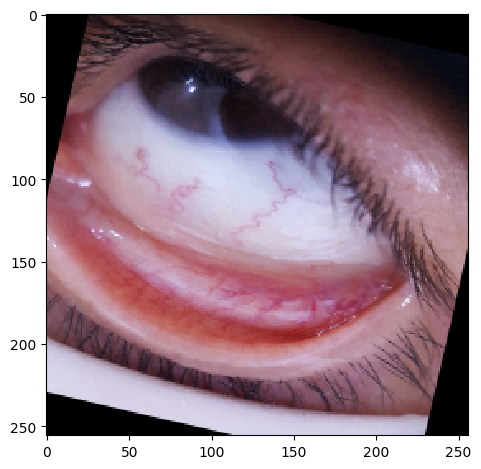

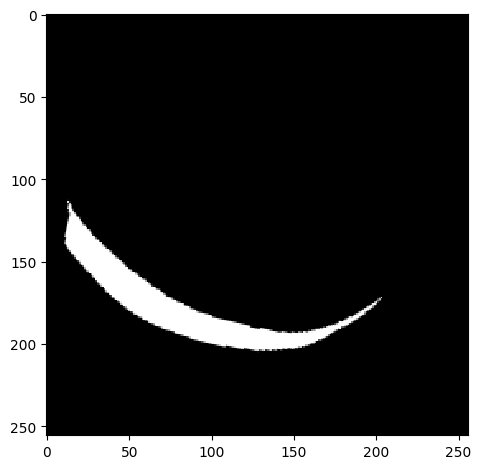

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
imshow(X_train[1000])
plt.show()
imshow(np.squeeze(Y_train[1000]))
plt.show()

In [ ]:
import tensorflow as tf
IMG_CHANNELS = 3
# Unet architecture
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [ ]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_anemia_segmen.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)


Epoch 1/5
76/76 [==============================] - 41s 269ms/step - loss: 0.5431 - accuracy: 0.7790 - val_loss: 0.4396 - val_accuracy: 0.8300
Epoch 2/5
76/76 [==============================] - 14s 181ms/step - loss: 0.4352 - accuracy: 0.8168 - val_loss: 0.4049 - val_accuracy: 0.8300
Epoch 3/5
76/76 [==============================] - 14s 182ms/step - loss: 0.4210 - accuracy: 0.8281 - val_loss: 0.4080 - val_accuracy: 0.8474
Epoch 4/5
76/76 [==============================] - 14s 184ms/step - loss: 0.4060 - accuracy: 0.8402 - val_loss: 0.3767 - val_accuracy: 0.8597
Epoch 5/5
76/76 [==============================] - 14s 190ms/step - loss: 0.3920 - accuracy: 0.8454 - val_loss: 0.3849 - val_accuracy: 0.8581


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 14s 185ms/step - loss: 0.4134 - accuracy: 0.8381 - val_loss: 0.3929 - val_accuracy: 0.8469
Epoch 2/5
76/76 [==============================] - 14s 183ms/step - loss: 0.4024 - accuracy: 0.8394 - val_loss: 0.3638 - val_accuracy: 0.8551
Epoch 3/5
76/76 [==============================] - 14s 183ms/step - loss: 0.3951 - accuracy: 0.8454 - val_loss: 0.3794 - val_accuracy: 0.8533
Epoch 4/5
76/76 [==============================] - 14s 184ms/step - loss: 0.3923 - accuracy: 0.8468 - val_loss: 0.3615 - val_accuracy: 0.8626
Epoch 5/5
76/76 [==============================] - 14s 190ms/step - loss: 0.3840 - accuracy: 0.8468 - val_loss: 0.3643 - val_accuracy: 0.8610


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 15s 191ms/step - loss: 0.3800 - accuracy: 0.8458 - val_loss: 0.3722 - val_accuracy: 0.8550
Epoch 2/5
76/76 [==============================] - 15s 194ms/step - loss: 0.3677 - accuracy: 0.8483 - val_loss: 0.3671 - val_accuracy: 0.8587
Epoch 3/5
76/76 [==============================] - 15s 193ms/step - loss: 0.3541 - accuracy: 0.8549 - val_loss: 0.7111 - val_accuracy: 0.6569
Epoch 4/5
76/76 [==============================] - 15s 191ms/step - loss: 0.3323 - accuracy: 0.8686 - val_loss: 0.2937 - val_accuracy: 0.8831
Epoch 5/5
76/76 [==============================] - 14s 185ms/step - loss: 0.3128 - accuracy: 0.8739 - val_loss: 0.3861 - val_accuracy: 0.8470


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 15s 191ms/step - loss: 0.3171 - accuracy: 0.8720 - val_loss: 0.3173 - val_accuracy: 0.8745
Epoch 2/5
76/76 [==============================] - 14s 190ms/step - loss: 0.2879 - accuracy: 0.8804 - val_loss: 0.4849 - val_accuracy: 0.7617
Epoch 3/5
76/76 [==============================] - 15s 193ms/step - loss: 0.2980 - accuracy: 0.8717 - val_loss: 0.3394 - val_accuracy: 0.8463


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 14s 181ms/step - loss: 0.2566 - accuracy: 0.8917 - val_loss: 0.2393 - val_accuracy: 0.8970
Epoch 2/5
76/76 [==============================] - 14s 181ms/step - loss: 0.2499 - accuracy: 0.8953 - val_loss: 0.2924 - val_accuracy: 0.8787
Epoch 3/5
76/76 [==============================] - 14s 184ms/step - loss: 0.2297 - accuracy: 0.9028 - val_loss: 0.2085 - val_accuracy: 0.9150
Epoch 4/5
76/76 [==============================] - 14s 187ms/step - loss: 0.2185 - accuracy: 0.9091 - val_loss: 0.2940 - val_accuracy: 0.8808
Epoch 5/5
76/76 [==============================] - 14s 188ms/step - loss: 0.2373 - accuracy: 0.9027 - val_loss: 0.3474 - val_accuracy: 0.8287


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 14s 183ms/step - loss: 0.1990 - accuracy: 0.9164 - val_loss: 0.3496 - val_accuracy: 0.8287
Epoch 2/5
76/76 [==============================] - 14s 182ms/step - loss: 0.2019 - accuracy: 0.9145 - val_loss: 0.3431 - val_accuracy: 0.8544
Epoch 3/5
76/76 [==============================] - 14s 182ms/step - loss: 0.1797 - accuracy: 0.9259 - val_loss: 0.2109 - val_accuracy: 0.9084
Epoch 4/5
76/76 [==============================] - 14s 181ms/step - loss: 0.1562 - accuracy: 0.9354 - val_loss: 0.1484 - val_accuracy: 0.9381
Epoch 5/5
76/76 [==============================] - 14s 180ms/step - loss: 0.1482 - accuracy: 0.9375 - val_loss: 0.2109 - val_accuracy: 0.9101


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 14s 177ms/step - loss: 0.1432 - accuracy: 0.9407 - val_loss: 0.1805 - val_accuracy: 0.9299
Epoch 2/5
76/76 [==============================] - 13s 175ms/step - loss: 0.1323 - accuracy: 0.9438 - val_loss: 0.1674 - val_accuracy: 0.9317
Epoch 3/5
76/76 [==============================] - 13s 177ms/step - loss: 0.1140 - accuracy: 0.9518 - val_loss: 0.2190 - val_accuracy: 0.9114
Epoch 4/5
76/76 [==============================] - 14s 183ms/step - loss: 0.1051 - accuracy: 0.9553 - val_loss: 0.1137 - val_accuracy: 0.9496
Epoch 5/5
76/76 [==============================] - 14s 181ms/step - loss: 0.1401 - accuracy: 0.9431 - val_loss: 0.2009 - val_accuracy: 0.9238


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 15s 191ms/step - loss: 0.1003 - accuracy: 0.9572 - val_loss: 0.1116 - val_accuracy: 0.9522
Epoch 2/5
76/76 [==============================] - 14s 188ms/step - loss: 0.0737 - accuracy: 0.9663 - val_loss: 0.0948 - val_accuracy: 0.9581
Epoch 3/5
76/76 [==============================] - 14s 185ms/step - loss: 0.0614 - accuracy: 0.9710 - val_loss: 0.1291 - val_accuracy: 0.9525
Epoch 4/5
76/76 [==============================] - 14s 185ms/step - loss: 0.0662 - accuracy: 0.9692 - val_loss: 0.1219 - val_accuracy: 0.9461


In [ ]:
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
76/76 [==============================] - 14s 184ms/step - loss: 0.0624 - accuracy: 0.9708 - val_loss: 0.1100 - val_accuracy: 0.9544
Epoch 2/5
76/76 [==============================] - 14s 188ms/step - loss: 0.0723 - accuracy: 0.9683 - val_loss: 0.1177 - val_accuracy: 0.9495
Epoch 3/5
76/76 [==============================] - 15s 191ms/step - loss: 0.0666 - accuracy: 0.9694 - val_loss: 0.0770 - val_accuracy: 0.9653
Epoch 4/5
76/76 [==============================] - 14s 185ms/step - loss: 0.0475 - accuracy: 0.9763 - val_loss: 0.0942 - val_accuracy: 0.9624
Epoch 5/5
76/76 [==============================] - 14s 183ms/step - loss: 0.0475 - accuracy: 0.9771 - val_loss: 0.0797 - val_accuracy: 0.9677


5/5 [==============================] - 0s 82ms/step


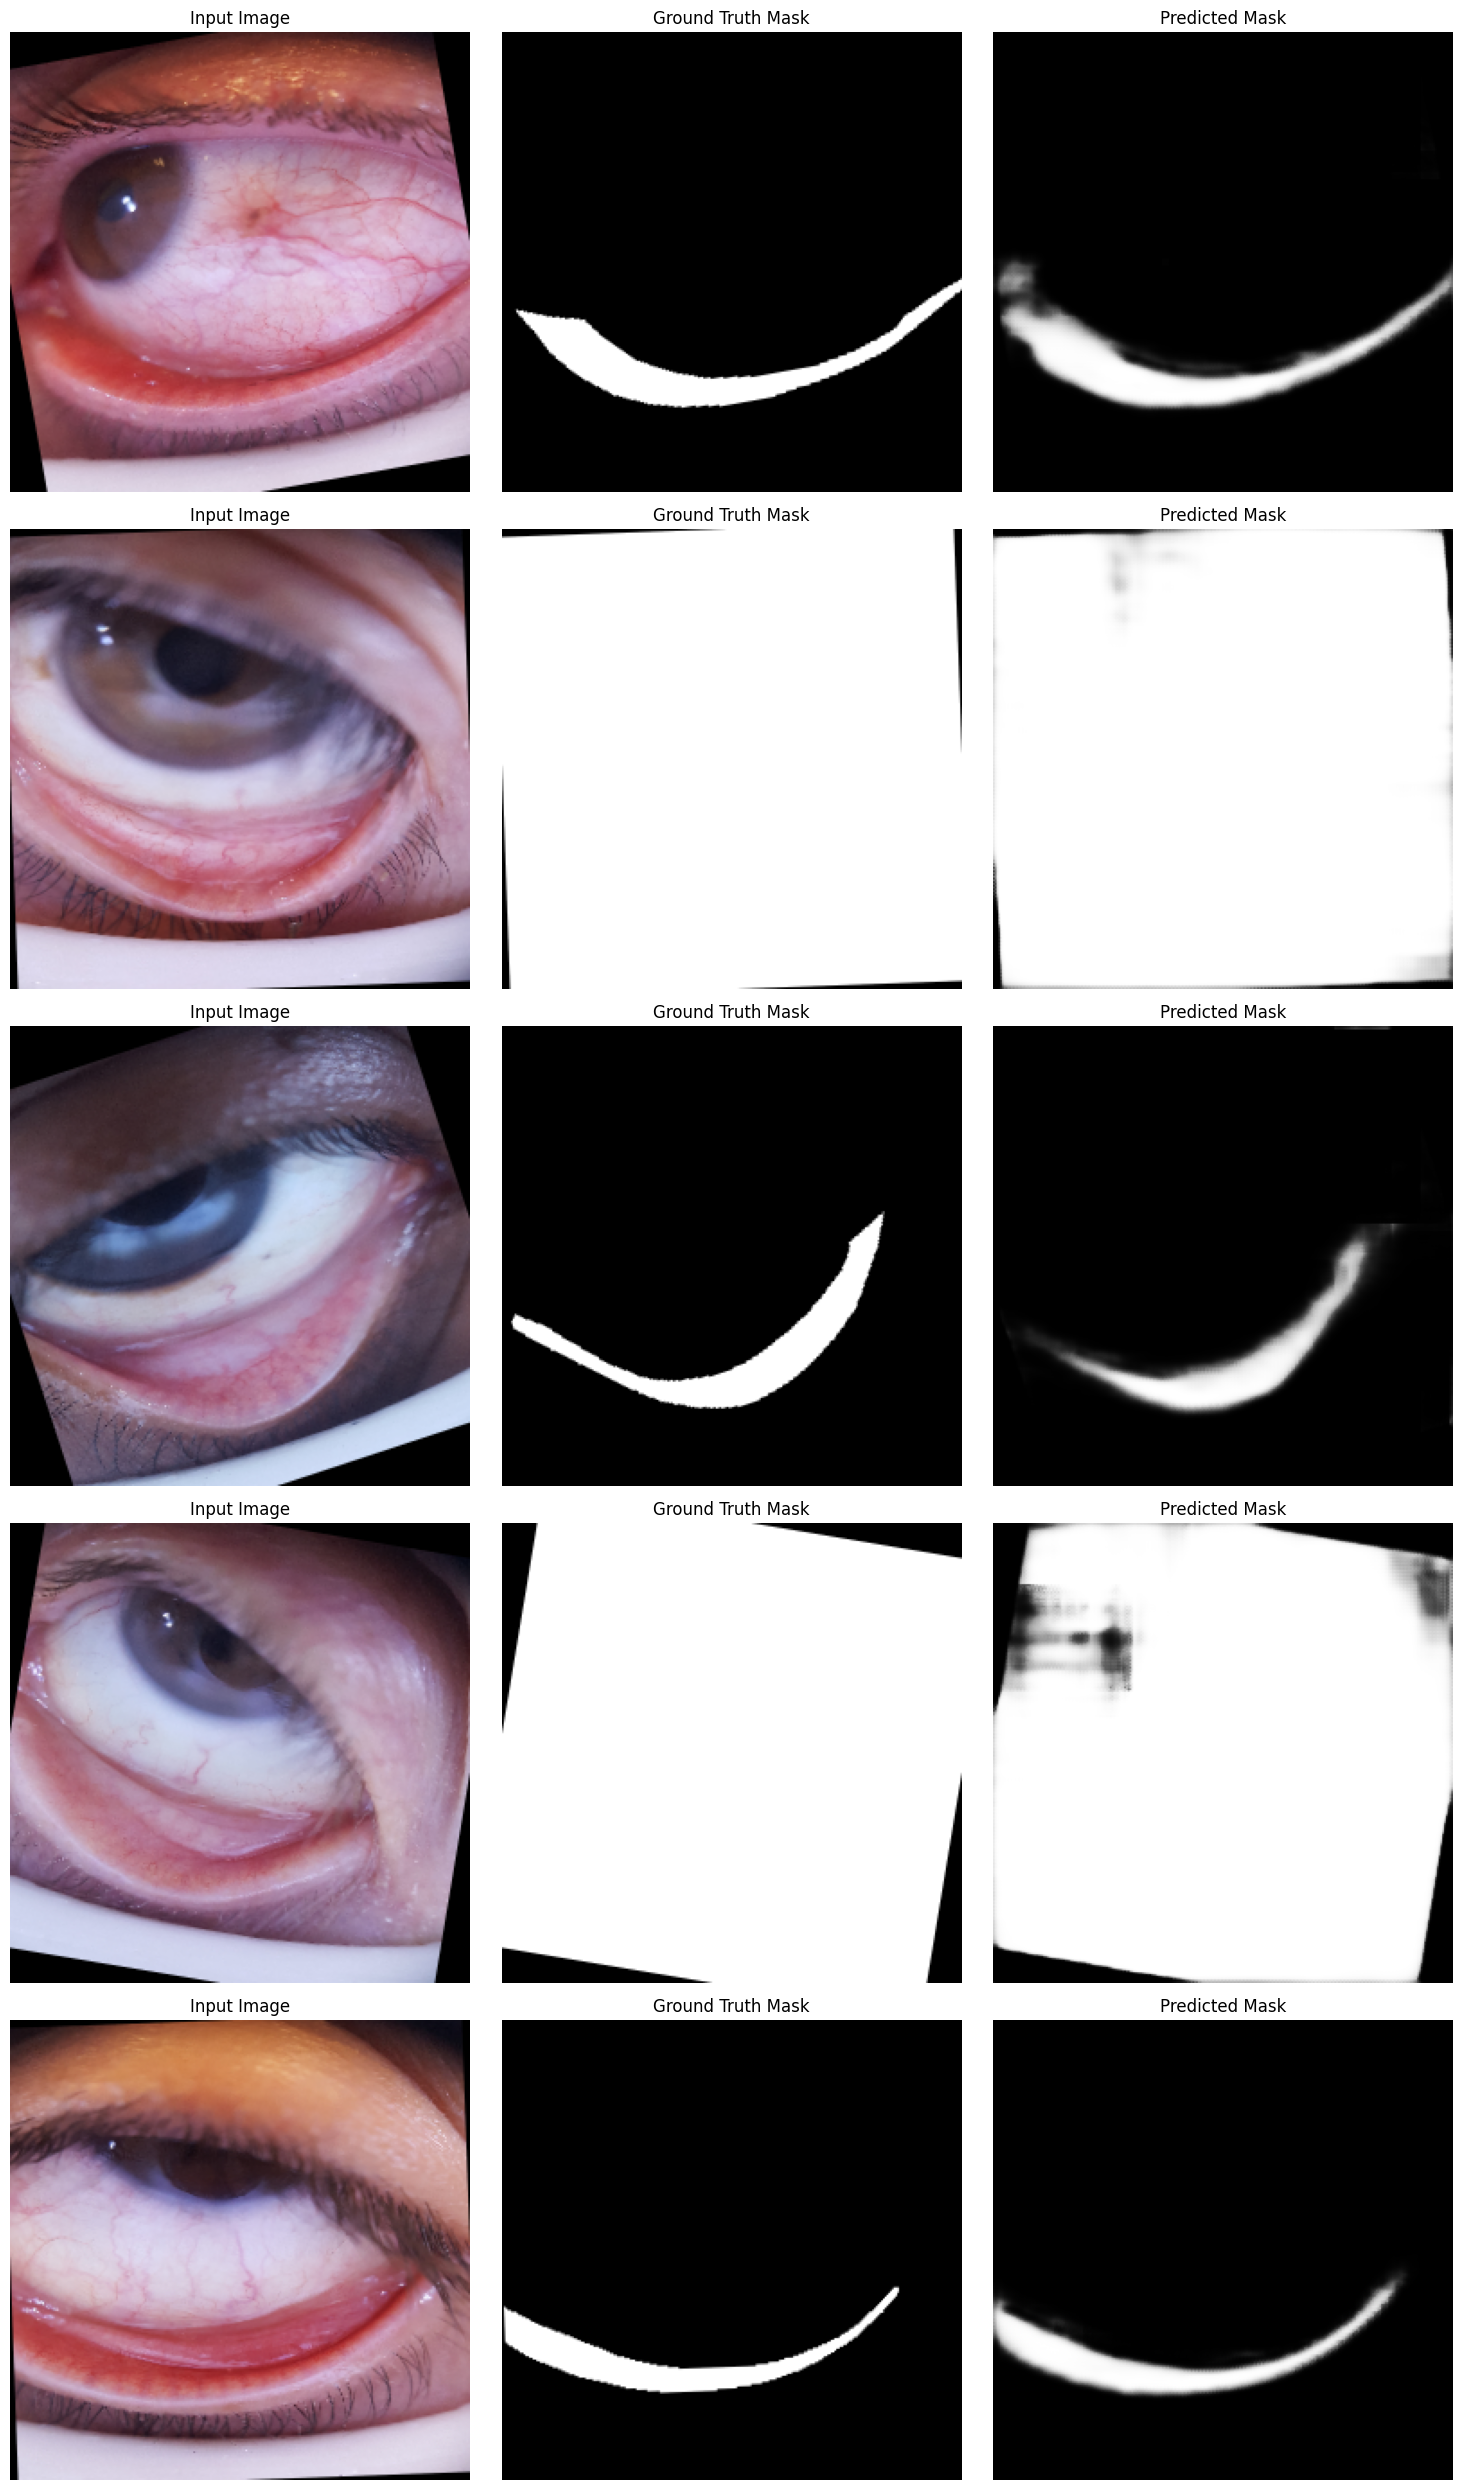

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your validation data as X_val and Y_val
predicted_masks = model.predict(X_val)

def plot_predictions(X_val, Y_val, predicted_masks, num_samples=5):
    # Select a few samples to display
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i, idx in enumerate(indices):
        # Original Image
        axes[i, 0].imshow(X_val[idx])
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(Y_val[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(predicted_masks[idx].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(X_val, Y_val, predicted_masks)


In [ ]:
import random
# Generate a random index for demonstration
idx = random.randint(0, len(X_train) - 1)

# Make predictions
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Apply thresholding to convert probabilities to binary values (0 or 1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Optionally, print shapes or inspect a random prediction
print(f"Training predictions shape: {preds_train_t.shape}")
print(f"Validation predictions shape: {preds_val_t.shape}")
print(f"Test predictions shape: {preds_test_t.shape}")

# Example to inspect a random prediction
print(f"Random index: {idx}")
print(f"Random training prediction (original): {preds_train[idx]}")
print(f"Random training prediction (thresholded): {preds_train_t[idx]}")

5/5 [==============================] - 0s 58ms/step
Training predictions shape: (1204, 256, 256, 1)
Validation predictions shape: (150, 256, 256, 1)
Test predictions shape: (151, 256, 256, 1)
Random index: 149
Random training prediction (original): [[[1.3340912e-02]
  [6.9764809e-04]
  [3.2459272e-04]
  ...
  [3.8687763e-04]
  [3.3904857e-03]
  [4.5690764e-02]]

 [[7.8091765e-04]
  [1.9540619e-05]
  [3.1631728e-06]
  ...
  [4.7818326e-06]
  [1.1458921e-04]
  [5.9885844e-03]]

 [[3.1394191e-04]
  [2.2414001e-06]
  [5.2163250e-07]
  ...
  [4.6530815e-07]
  [2.3377917e-05]
  [2.2407125e-03]]

 ...

 [[3.4573686e-10]
  [7.2189732e-12]
  [2.1199709e-18]
  ...
  [1.5983183e-08]
  [2.1379074e-05]
  [8.1873289e-04]]

 [[4.4394442e-06]
  [4.7315382e-08]
  [1.2299806e-12]
  ...
  [5.6714285e-05]
  [2.3195121e-04]
  [4.7118394e-03]]

 [[3.2427753e-04]
  [6.3176949e-06]
  [1.6013230e-09]
  ...
  [1.6006663e-03]
  [3.8009123e-03]
  [1.9377399e-02]]]
Random training prediction (thresholded): [[[0]
 

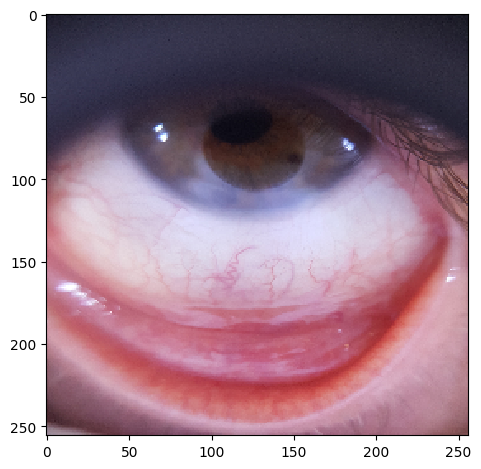

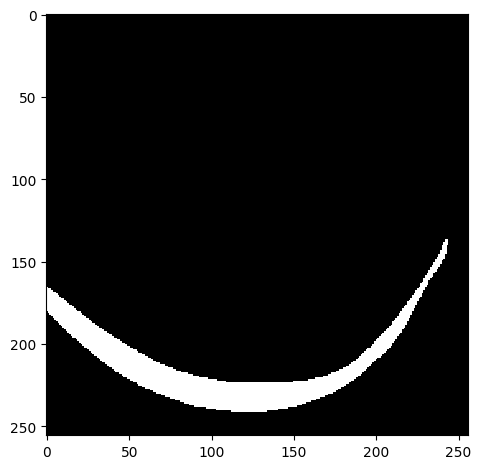

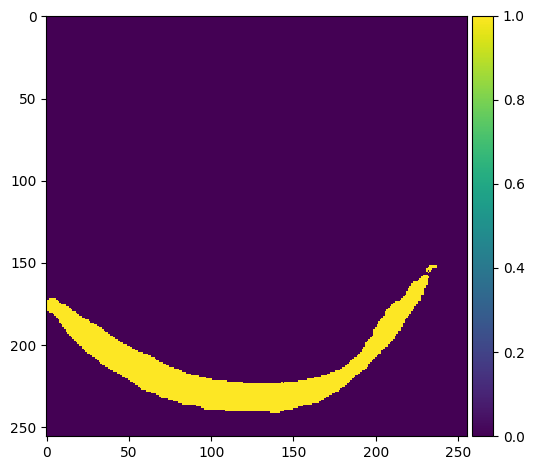

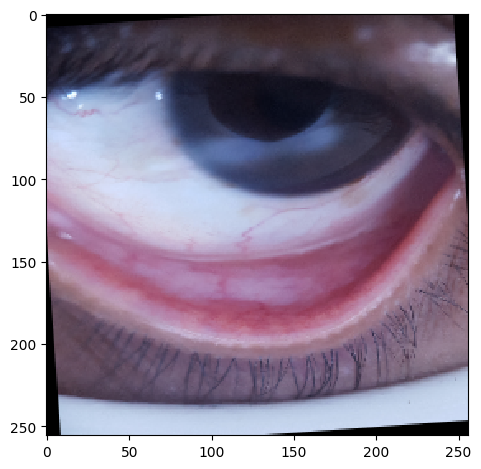

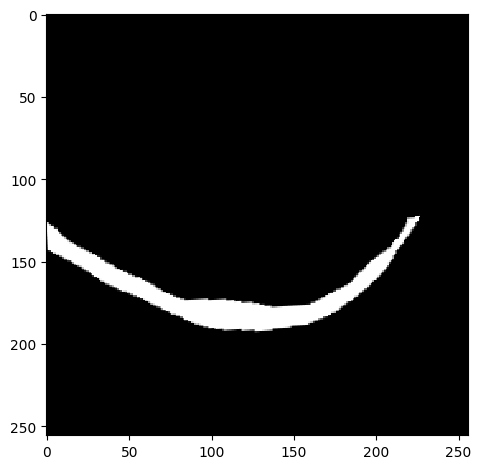

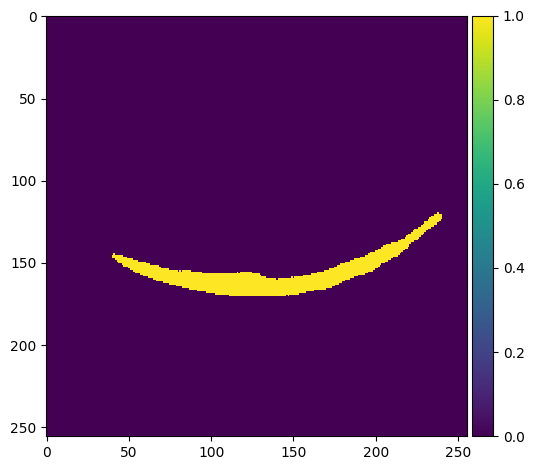

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/model_for_anemia_segmen_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [ ]:
def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_coefficient(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice_score = 2. * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score


In [ ]:
# Ensure ground truth labels are binary (0 or 1)
Y_train_bin = (Y_train > 0.5).astype(np.uint8)
Y_val_bin = (Y_val > 0.5).astype(np.uint8)
Y_test_bin = (Y_test > 0.5).astype(np.uint8)

# Flatten the arrays for metric calculations
Y_train_flat = Y_train_bin.flatten()
Y_val_flat = Y_val_bin.flatten()
Y_test_flat = Y_test_bin.flatten()
preds_train_flat = preds_train_t.flatten()
preds_val_flat = preds_val_t.flatten()
preds_test_flat = preds_test_t.flatten()


In [ ]:
# Compute metrics for training set
train_accuracy = accuracy_score(Y_train_flat, preds_train_flat)
train_precision = precision_score(Y_train_flat, preds_train_flat)
train_recall = recall_score(Y_train_flat, preds_train_flat)
train_f1 = f1_score(Y_train_flat, preds_train_flat)
train_iou = iou(Y_train_flat, preds_train_flat)
train_dice = dice_coefficient(Y_train_flat, preds_train_flat)

# Compute metrics for validation set
val_accuracy = accuracy_score(Y_val_flat, preds_val_flat)
val_precision = precision_score(Y_val_flat, preds_val_flat)
val_recall = recall_score(Y_val_flat, preds_val_flat)
val_f1 = f1_score(Y_val_flat, preds_val_flat)
val_iou = iou(Y_val_flat, preds_val_flat)
val_dice = dice_coefficient(Y_val_flat, preds_val_flat)

# Compute metrics for test set
test_accuracy = accuracy_score(Y_test_flat, preds_test_flat)
test_precision = precision_score(Y_test_flat, preds_test_flat)
test_recall = recall_score(Y_test_flat, preds_test_flat)
test_f1 = f1_score(Y_test_flat, preds_test_flat)
test_iou = iou(Y_test_flat, preds_test_flat)
test_dice = dice_coefficient(Y_test_flat, preds_test_flat)

# Print metrics
print(f"Training set: Accuracy = {train_accuracy}, Precision = {train_precision}, Recall = {train_recall}, F1-score = {train_f1}, IoU = {train_iou}, Dice coefficient = {train_dice}")
print(f"Validation set: Accuracy = {val_accuracy}, Precision = {val_precision}, Recall = {val_recall}, F1-score = {val_f1}, IoU = {val_iou}, Dice coefficient = {val_dice}")
print(f"Test set: Accuracy = {test_accuracy}, Precision = {test_precision}, Recall = {test_recall}, F1-score = {test_f1}, IoU = {test_iou}, Dice coefficient = {test_dice}")

Training set: Accuracy = 0.9851326926602082, Precision = 0.9612345875579378, Recall = 0.9554986796271868, F1-score = 0.9583580511151898, IoU = 0.9200455608966353, Dice coefficient = 0.9583580511151897
Validation set: Accuracy = 0.9722724405924479, Precision = 0.9264383041367036, Recall = 0.9047334702510499, F1-score = 0.915457253763471, IoU = 0.8440951331242575, Dice coefficient = 0.9154572537634709
Test set: Accuracy = 0.9738973655448054, Precision = 0.9384649099185265, Recall = 0.905122585121176, F1-score = 0.9214922400986189, IoU = 0.8544141028553006, Dice coefficient = 0.9214922400986187


In [1]:
from tensorflow.keras.models import load_model

# Load the trained UNet model
model = load_model('/content/drive/MyDrive/model_for_anemia_segmen_final.h5')


In [8]:
import cv2
import numpy as np
from skimage.io import imread, imshow

def preprocess_input_image(image_path, target_size):
    image_width , image_heigth = target_size
    # Load the input image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to the target size expected by the model
    image_resized = cv2.resize(image, dsize=(image_width, image_heigth), interpolation=cv2.INTER_CUBIC)
    image_preprocessed = np.expand_dims(image_resized, axis=0)

    return image_preprocessed, image
IMG_WIDTH, IMG_HEIGHT = (256, 256)
input_image_path = '/content/drive/MyDrive/dataset anemia (1)/India/50/20200217_154641.jpg'
input_image_preprocessed, original_image = preprocess_input_image(input_image_path, (IMG_WIDTH, IMG_HEIGHT))


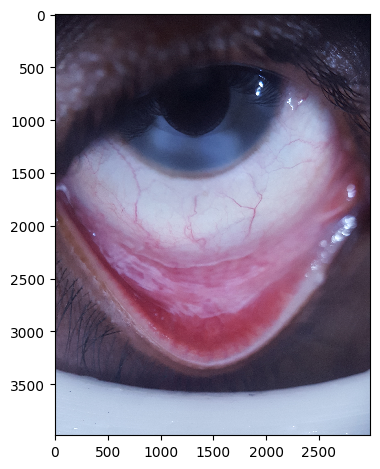

In [9]:
imshow(original_image)

In [10]:
# Predict the mask using the trained model
predicted_mask = model.predict(input_image_preprocessed)
# Remove batch dimension and resize mask to the original image size
predicted_mask_resized = cv2.resize(predicted_mask[0], (original_image.shape[1], original_image.shape[0]))


1/1 [==============================] - 0s 183ms/step


1/1 [==============================] - 0s 194ms/step


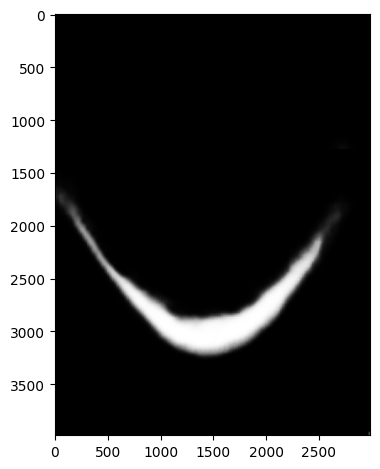

In [11]:
from skimage.io import imread, imshow
# Predict the mask using the trained model
predicted_mask = model.predict(input_image_preprocessed)
# Remove batch dimension and resize mask to the original image size
predicted_mask_resized = cv2.resize(predicted_mask[0], (original_image.shape[1], original_image.shape[0]))
imshow(predicted_mask_resized)


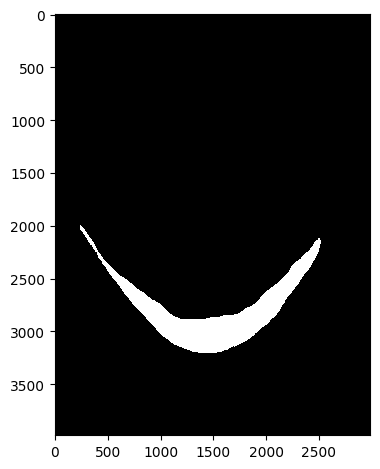

In [12]:
# Threshold the mask to create a binary mask
binary_mask = (predicted_mask_resized > 0.5).astype(np.uint8) * 255
imshow(binary_mask)


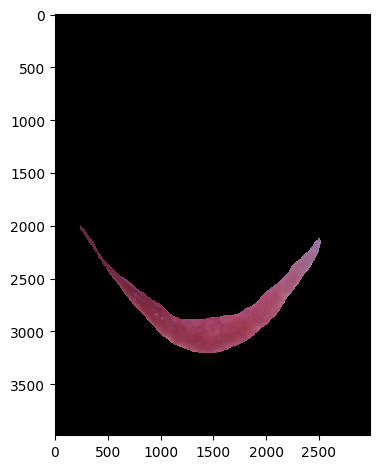

In [13]:
# Extract the ROI using the binary mask
roi = cv2.bitwise_and(original_image, original_image, mask=binary_mask)

# Optionally, display the images
imshow(original_image)
imshow(binary_mask)
imshow(roi)
